# The regression experiment by Thalia Ghali

## is the price correlated to distance to nearest station

## for each meter away from subway station how does the price vary

we start by importing the usual suspects

In [5]:
# import data science libraries



# import data science library with added geographic functions
import geopandas as gpd

import pandas as pd

import seaborn as sns

# useful to calculate the Ordinary Least Square linear regression

import statsmodels.api as sm

# useful to get fast distance calculation, 
# see https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html
from sklearn.neighbors import BallTree 

# useful to access functions like median, mean or std 
from scipy import stats 

# useful to get map background but hard to install...
# If not available REMOVE this
import contextily as cx

sns.set_style("white")

## 1 – Real Estate dataset: Anjuke

This dataset has been created in UTSEUS in 2017. The souce page for it is (anjuke)[https://shanghai.anjuke.com/sale]

This dataset is given to you as a (pickle)[https://docs.python.org/3/library/pickle.html] which can be used directly as a variable.
The format is called pickle, it is like a zip but can only be read in python. 

In [6]:
# change path to your PATH. if the file can be seen on the left you can just put the file name directly
real_estate_file = 'utseus-anjuke-real-estate.pk'
anjuke = pd.read_pickle(real_estate_file)

the pickle is just a list of list. The first item is the columns name, the rest is the data
The dataframe need to have the data first, and the name of the columns separately. 
We use (list comprehension)[https://docs.python.org/3/tutorial/introduction.html#lists] to achieve this.

In [7]:
anjuke_df = pd.DataFrame(anjuke[1:],columns=anjuke[0], )

Use .info or .describe functions to get a better idea of the dataset

In [8]:
anjuke_df.info()
anjuke_df.describe()
anjuke_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467029 entries, 0 to 467028
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              467029 non-null  object
 1   address         467029 non-null  object
 2   longitude       467029 non-null  object
 3   latitude        467029 non-null  object
 4   bedroom         467029 non-null  object
 5   room            467029 non-null  object
 6   surface         467029 non-null  object
 7   price           467029 non-null  object
 8   onesquaremeter  467029 non-null  object
 9   tags            467029 non-null  object
 10  district        467029 non-null  object
 11  neighborhood    467029 non-null  object
 12  done            467029 non-null  object
dtypes: object(13)
memory usage: 46.3+ MB


,id,address,longitude,latitude,bedroom,room,surface,price,onesquaremeter,tags,district,neighborhood,done
0,A888553302,宝山-大场 金地艺境(宝山)(555弄),121.34392735101,31.3193561718426,2,2,30.0,1160000.0,38666.6666666667,金地开发 **首推 地铁首通 价格首降 配套就是你能想到的,baoshan,dachang,1
1,A888376847,宝山-大场 骏华苑,121.407324884273,31.3023675431043,1,1,38.0,1950000.0,51315.7894736842,龙璟公馆嘉兴市近万达广场，北大附属实验校区，地铁沿线高铁站旁,baoshan,dachang,1
2,A885088482,宝山-大场 琉樽尚品(255弄),121.397487377268,31.2908711986862,3,2,92.0,5350000.0,58152.1739130435,92+7平书房，婚房装修30万！满2年税少11万！再降20万,baoshan,dachang,1
3,A885392981,宝山-大场 琉樽尚品（255弄）,121.397487377268,31.2908711986862,2,2,68.0,4350000.0,63970.5882352941,中环景观，电梯复式，豪装45万全送，拎包入住，小格局大设计，,baoshan,dachang,1
4,A885831305,宝山-大场 美好家小区,121.421397234518,31.302658471085,2,2,80.0,4000000.0,50000.0,美好家南北通精装2房板式房型采光好随时好看带天井,baoshan,dachang,1


all of the field we see in the columns are object and have not been correctly imported as numbers. Consequently we cannot calculate with these columns as they are considered as words. We need numbers. To convert from words to numbers we use a special function from python. 

All numeric columns shall transformed into floats using pandas (to_numeric)[https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html] function.

In [9]:
numeric_columns = ['longitude', 'latitude', 'bedroom', 'room', 'surface', 'price', 'onesquaremeter']

# put the function in the following line
anjuke_df[numeric_columns] = anjuke_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

now we can have some numbers that could not be converted. the rows containing these undefined values need to be dropped. 

Do that using the function (dropna)[https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html]

In [9]:
anjuke_df = anjuke_df.dropna()

check if the colums have been successfully changed.

You should observe that we 'lost' 3962 records that were incomplete with a non numeric data

use .info() again

In [10]:
anjuke_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 463067 entries, 0 to 467028
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              463067 non-null  object 
 1   address         463067 non-null  object 
 2   longitude       463067 non-null  float64
 3   latitude        463067 non-null  float64
 4   bedroom         463067 non-null  int64  
 5   room            463067 non-null  int64  
 6   surface         463067 non-null  float64
 7   price           463067 non-null  float64
 8   onesquaremeter  463067 non-null  float64
 9   tags            463067 non-null  object 
 10  district        463067 non-null  object 
 11  neighborhood    463067 non-null  object 
 12  done            463067 non-null  object 
dtypes: float64(5), int64(2), object(6)
memory usage: 49.5+ MB


Time to tranform the dataset into a geodataframe now so we can perform geographic operations

Right now we just have GPS has numbers in columns. This is not ready to be used on a map. For that we need to convert it into a geographic object that can be a point, a line or a polygon. In our case it is a point 

In [11]:
anjuke_gdf = gpd.GeoDataFrame(
        anjuke_df, 
        geometry=gpd.points_from_xy(anjuke_df.longitude, anjuke_df.latitude), crs=4326)

plot the data on a map using the plot function with the following properties
plot(markersize=0.5, color='black', figsize=(10,10))

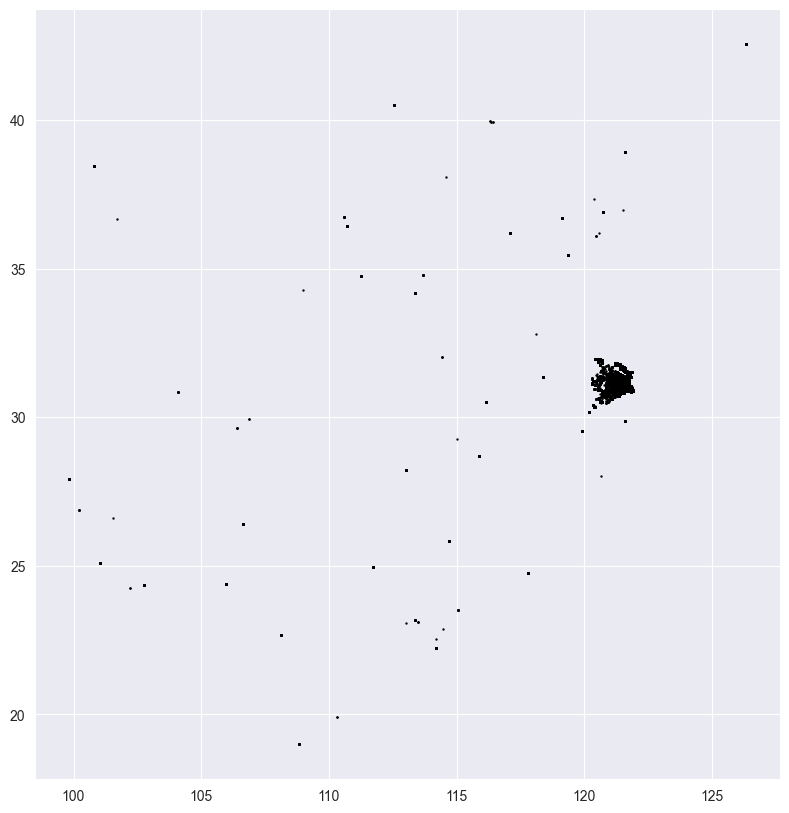

In [12]:
import matplotlib.pyplot as plt
anjuke_gdf.plot(markersize=0.5, color='black', figsize=(10, 10))
plt.show()

We observe that data are not only in Shanghai. 

Write HERE why you think it is like this ?

Sûrement à cause d'erreurs dans les données. On possédait un jeu de données assez conséquent, certains ont pus être mal saisies.






To have an idea of the spread of data, we can print or we can check the boundaries using the property (total_bounds)[https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.total_bounds.html]

In [18]:
# use the property and print the result

anjuke_gdf.total_bounds

array([ 99.82410591,  18.99369628, 126.33039253,  42.54940926])

In both cases, it seems there are data outside Shanghai.

To limit it we have two options:
- one is to use _cx_ to specify a bounding box
- another one is to provide a shape for the area and filter points within

### Lets start with bounding box

to find the bounding box you can use GIS or search for it. we can use [bboxfinder.com](http://bboxfinder.com/)  for example

In [19]:
print(f'before {len(anjuke_gdf)}')
west = 120.85
east = 121.99
north = 31.89
south = 30.60

xmin, ymin, xmax, ymax = (west,south,east,north)
anjuke_filterbb_gdf = anjuke_gdf.cx[xmin:xmax, ymin:ymax]
print(f'after {len(anjuke_filterbb_gdf)}')

before 463067
after 454134


we check if the latitude or longitude we have is in GCJ format of GPS format by looking at the huangpu river

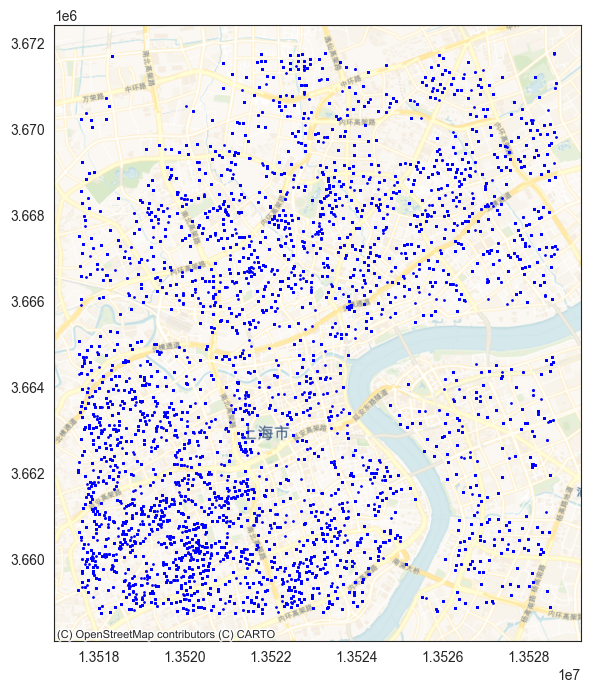

In [20]:
ax = anjuke_filterbb_gdf.cx[121.43:121.53, 31.20:31.30].to_crs(3857).plot(markersize=1, color='b', figsize=(8,8))

# use plot with ax here if you dont have cx
ax.plot(markersize=1, color='b', figsize=(8,8))
# use cx here if you have it
cx.add_basemap(ax,source=cx.providers.CartoDB.Voyager)

## 2 – POI dataset: Gaode

This dataset has been bought from Gaode for SHU Cendus institute in 2020. We choose the POI from 2017 to be consistant with the anjuke dataset also from 2017 

In [13]:
poi_df = pd.read_csv('shanghaiPOI2017.csv',delimiter=';', decimal=',', low_memory=False)

In [14]:
poi_df.columns

Index(['Unnamed: 0', 'ID', 'POIID', 'GCJX', 'GCJY', 'NAME', 'ADD', 'TEL',
       'TYPE', 'AREAID', 'IDKEY', 'GPSX', 'GPSY', 'TYPE1', 'TYPE2', 'TYPE3',
       'TYPE4', 'TYPE5', 'TYPE3.1', 'TYPE3.2', 'TYPE3.3', 'TYPE1.N', 'TYPE2.N',
       'TYPE3.N', 'TYPE3.1.N', 'TYPECODE', 'GBCODE'],
      dtype='object')

find the GBCode corresponding to subway stations. one column seems to have a text, we can search in the text.

In [15]:
poi_df[poi_df.TYPECODE.str.contains('地铁')].loc[:,['TYPECODE','GBCODE']]

,TYPECODE,GBCODE
69644,交通设施服务;地铁站;出入口,200402.0
69645,交通设施服务;地铁站;出入口,200402.0
69646,交通设施服务;地铁站;出入口,200402.0
69647,交通设施服务;地铁站;出入口,200402.0
69648,交通设施服务;地铁站;出入口,200402.0
...,...,...
71345,交通设施服务;地铁站;地铁站,200401.0
71346,交通设施服务;地铁站;地铁站,200401.0
71347,交通设施服务;地铁站;地铁站,200401.0
71348,交通设施服务;地铁站;地铁站,200401.0


it looks like the subway stations have a GBCode of XXXX.

The complete description of China BGCode used to categorize POI information can be found [GB/T 35648-2017 ](https://openstd.samr.gov.cn/bzgk/gb/newGbInfo?hcno=3330BB5A1FF81A61F8A7432B0BB4AE01)

In [18]:
# fill in the gbcode you found
GBCODE = 200402.0
poi_subway_df = poi_df[poi_df.GBCODE == GBCODE]

we proceed similarly with this dataframe and convert it to a geodataframe. Use the same technic as before

In [22]:
# write the function to create the geodataframe here usin gthe same method as before
poi_subway_gdf = gpd.GeoDataFrame(
    poi_subway_df,
    geometry=gpd.points_from_xy(poi_subway_df['GCJX'], poi_subway_df['GCJY']),
    crs=4326
)


        

<Axes: >

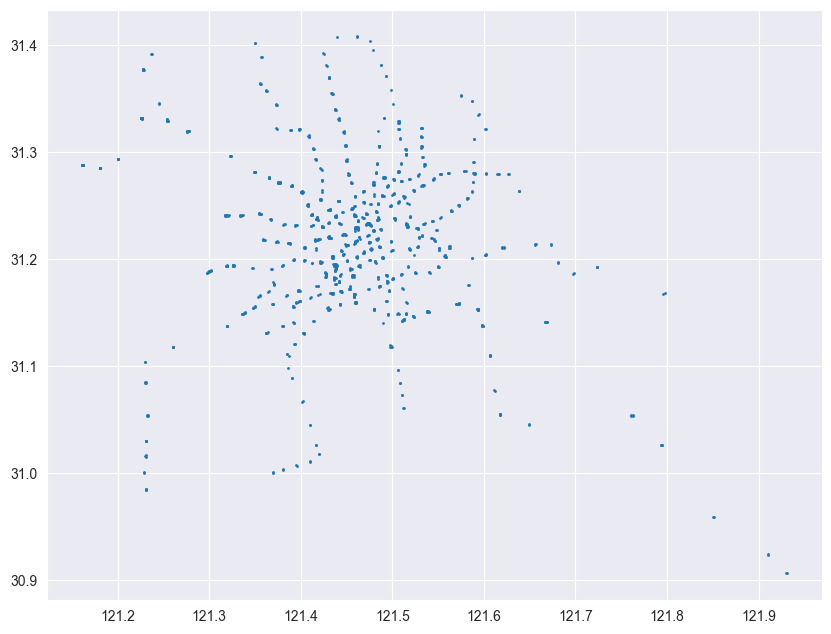

In [23]:
poi_subway_gdf.plot(markersize=1, figsize=(10,10))

Maintenant que nous avons un graphe pour les appartements et les stations de métro
à Shanghai j'aimerai suoerposer les deux et potzntiellement faire des calculs pour
#répondre à la question.



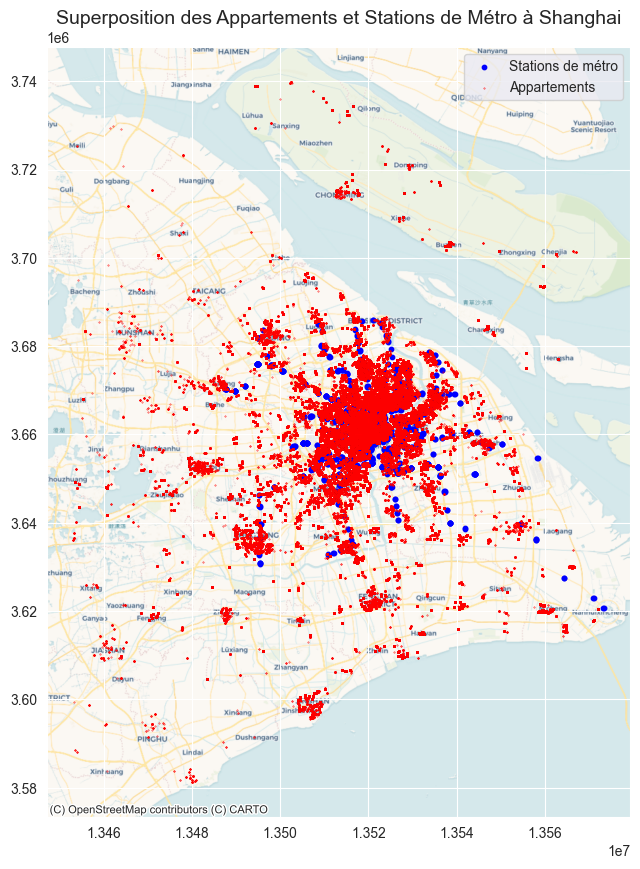

In [32]:
import matplotlib.pyplot as plt
import contextily as cx

# 1. Définir les bornes de Shanghai
west, east = 120.85, 121.99
south, north = 30.60, 31.89
xmin, ymin, xmax, ymax = west, south, east, north

# 2. Filtrer les appartements et les stations de métro dans cette zone
anjuke_filterbb_gdf = anjuke_gdf.cx[xmin:xmax, ymin:ymax]
poi_filterbb_gdf = poi_subway_gdf.cx[xmin:xmax, ymin:ymax]

# 3. Créer la figure
fig, ax = plt.subplots(figsize=(10, 10))

# 4. Tracer les stations de métro en BLEU
poi_filterbb_gdf.to_crs(epsg=3857).plot(
    ax=ax,
    markersize=10,
    color='blue',
    label='Stations de métro'
)

# 5. Tracer les appartements en ROUGE, avec une taille plus petite
anjuke_filterbb_gdf.to_crs(epsg=3857).plot(
    ax=ax,
    markersize=0.1,
    color='red',
    label='Appartements'
)

# 6. Ajouter un fond de carte clair avec les routes et le fleuve
cx.add_basemap(ax, source=cx.providers.CartoDB.Voyager)

# 7. Ajouter une légende et un titre
ax.legend()
ax.set_title("Superposition des Appartements et Stations de Métro à Shanghai", fontsize=14)

# 8. Afficher la carte
plt.show()



1. Calculer la distance entre chaque appartement et la station de métro la plus proche



In [34]:
from sklearn.neighbors import BallTree
import numpy as np

# Extraire les coordonnées des appartements et des stations de métro
apartments_coords = np.deg2rad(anjuke_filterbb_gdf.geometry.apply(lambda p: (p.y, p.x)).to_list())
subway_coords = np.deg2rad(poi_subway_gdf.geometry.apply(lambda p: (p.y, p.x)).to_list())

# Créer un BallTree pour les stations de métro
tree = BallTree(subway_coords, metric='haversine')

# Calculer la distance vers la station la plus proche (en mètres)
distances, _ = tree.query(apartments_coords, k=1)
dist_in_meters = distances * 6371000  # rayon moyen de la Terre en mètres

# ✅ Utilisation de `.loc[]` pour éviter le warning
anjuke_filterbb_gdf.loc[:, 'distance_to_nearest_station'] = dist_in_meters



2. Analyser la corrélation entre la distance et le prix

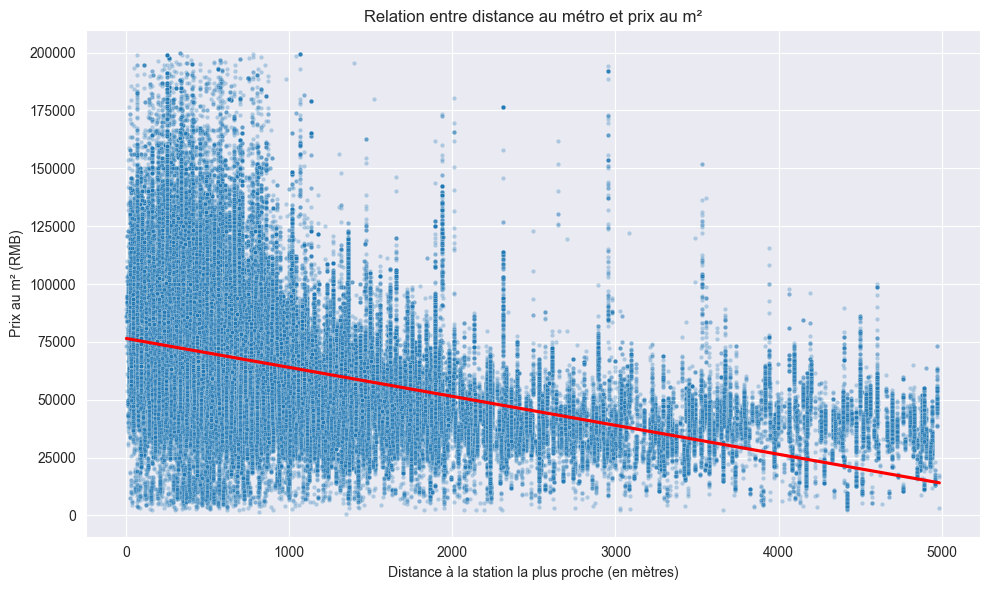

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# On récupère les deux colonnes utiles
df = anjuke_filterbb_gdf[['distance_to_nearest_station', 'onesquaremeter']].copy()

# On enlève les valeurs aberrantes (par exemple distance > 5000 m ou prix > 200000 RMB/m²)
df = df[(df['distance_to_nearest_station'] < 5000) & (df['onesquaremeter'] < 200000)]

# Création du graphique
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='distance_to_nearest_station', y='onesquaremeter', alpha=0.3, s=10)
sns.regplot(data=df, x='distance_to_nearest_station', y='onesquaremeter', scatter=False, color='red')

plt.xlabel('Distance à la station la plus proche (en mètres)')
plt.ylabel('Prix au m² (RMB)')
plt.title('Relation entre distance au métro et prix au m²')
plt.grid(True)
plt.tight_layout()
plt.show()


Étant donné que la droite rouge descend, alors plus on est proche du métro, plus le prix est élevé.


3. Régression linéaire pour prédire le prix en fonction de la distance

Coefficients : [-282.21259615]
Intercept : 7847710.0720895305


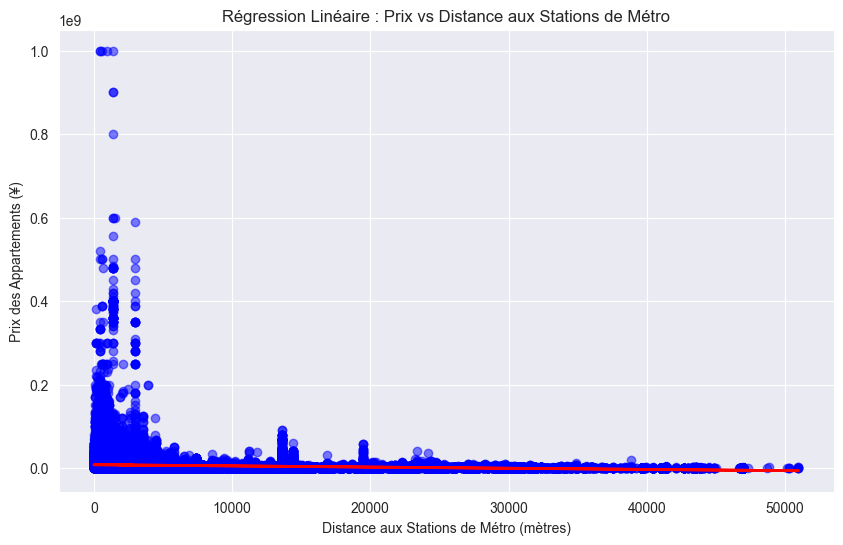

In [36]:
from sklearn.linear_model import LinearRegression

# Initialiser le modèle de régression
model = LinearRegression()

# X est la distance aux stations et Y est le prix des appartements
X = anjuke_filterbb_gdf[['distance_to_nearest_station']]
Y = anjuke_filterbb_gdf['price']

# Entraîner le modèle
model.fit(X, Y)

# Afficher les résultats de la régression
print(f"Coefficients : {model.coef_}")
print(f"Intercept : {model.intercept_}")

# Prédictions
predictions = model.predict(X)

# Tracer les résultats
plt.figure(figsize=(10,6))
plt.scatter(X, Y, color='blue', alpha=0.5)
plt.plot(X, predictions, color='red', linewidth=2)
plt.title('Régression Linéaire : Prix vs Distance aux Stations de Métro')
plt.xlabel('Distance aux Stations de Métro (mètres)')
plt.ylabel('Prix des Appartements (¥)')
plt.show()
